# Indexation d'images par la texture

## 1. Observations et expérimentations dans l'espace de Fourier

> Calculer le spectre en amplitude d'une image. Observer l'organisation des intensités maximales. Quelle relation observez-vous entre l'organisation des fréquences d'amplitude maximale et l'orientation du texte ?

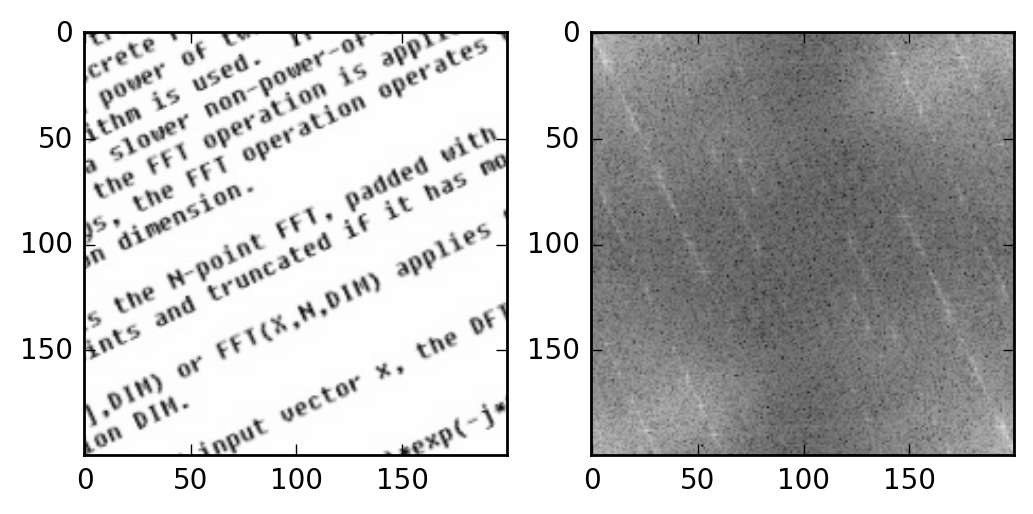

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
%matplotlib inline

img = imread('tp2.jpg')

transform = np.log(np.abs(np.fft.fft2(img)))

plt.subplot(121)
plt.imshow(img, cmap='Greys_r')
plt.subplot(122)
plt.imshow(transform, cmap='Greys_r')

On remarque que les fréquences d'amplitudes maximales sont orthogonales au texte dans la première image.

## 2. Construction d'un descripteur pour différentes classes de texture

> Ecrire une fonction descripteur qui applique le processus suivant: Nous travaillerons sur ces images converties en niveaux de gris (en calculant la moyenne de l'intensité en RGB). Sur chaque image en niveaux de gris, nous calculons la Transformée de Fourier 2D et nous produisons l'image du spectre en amplitude. Nous découpons la moitié supérieure en 6x3 blocs, puis nous calculons le logarithme de l'énergie moyenne sur chacun d'eux (i.e. la moyenne des coefficients au carré). Nous mémorisons enfin les 18 résultats pour chaque image.

In [2]:
def log_mean_energy(array):
    return np.log(np.mean(np.square(array)))


def descriptor(image, n_blocks = (3, 6)):
    grays = np.zeros(image.shape)
    # Moyennage de chaque pixel
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            grays[i][j] = np.mean(pixel)
    # Extraction de la valeur réelle (avec la fonction abs) de la FFT-2D
    transform = np.abs(np.fft.fft2(grays))
    # Découpage en blocs
    top = transform[:transform.shape[0] // 2, :] # Moitié supérieure
    x_step = top.shape[0] // n_blocks[0] # 100 // 3 = 33
    y_step = top.shape[1] // n_blocks[1] # 200 // 6 = 33
    return {
        '{}-{}'.format(i, j): log_mean_energy(top[x:x+x_step, y:y+y_step])
        for j, y in enumerate(range(0, top.shape[1] - y_step, y_step))
        for i, x in enumerate(range(0, top.shape[0] - x_step, x_step))
    }

descriptor(imread('img/50.jpg'))

{'0-0': 18.103565547179794,
 '0-1': 13.082310545668296,
 '0-2': 12.314375422676683,
 '0-3': 12.214765071501846,
 '0-4': 13.069642016286133,
 '0-5': 14.521817296039099,
 '1-0': 17.513515543670902,
 '1-1': 12.526732132767673,
 '1-2': 11.901133823110426,
 '1-3': 11.882265796232593,
 '1-4': 12.472619996713529,
 '1-5': 14.078107593230012,
 '2-0': 17.569240674330405,
 '2-1': 12.846672770873722,
 '2-2': 11.854946111911735,
 '2-3': 11.808473953936733,
 '2-4': 12.813062232255266,
 '2-5': 14.733393613553281}

Application du descripteur à chaque image.

In [3]:
from os import listdir
import time

debut = time.time()

descriptors = {
    i: descriptor(imread('img/{}'.format(image_file)))
    for i, image_file in enumerate(listdir('img/'))
}

fin = time.time()

print('{0:.2f} secondes au total'.format(fin - debut))
print('{0:.2f} secondes par image'.format((fin - debut) / len(descriptors)))

67.71 secondes au total
1.35 secondes par image


## 3. Calcul d'une distance et requête par l'exemple

> Ensuite, en appliquant une distance de Manhattan sur les 18 coefficients associés à chaque image, renvoyer les 10 images les plus proches (au sens de cette distance) d'une image requête identifiée par l'utilisateur.

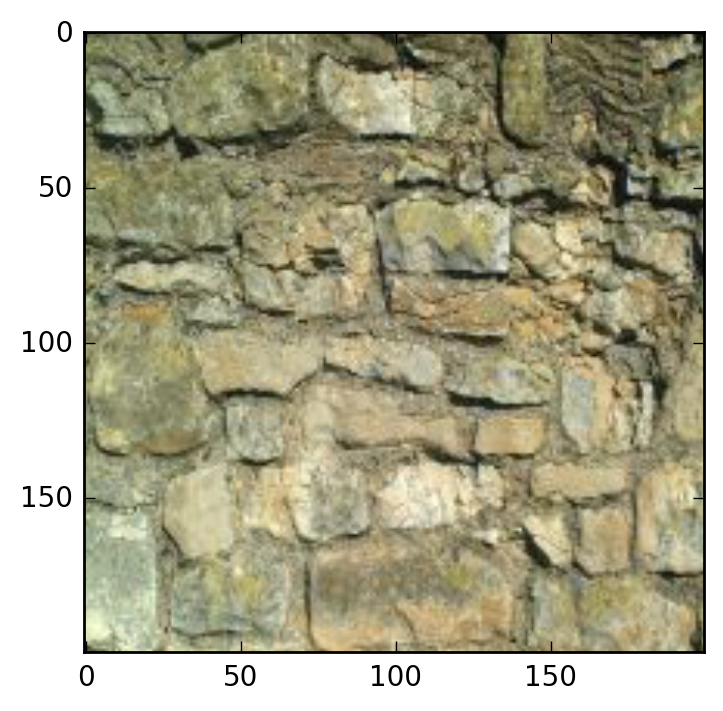

In [16]:
target_img = 1
plt.imshow(imread('img/{}.jpg'.format(str(target_img).zfill(2))))

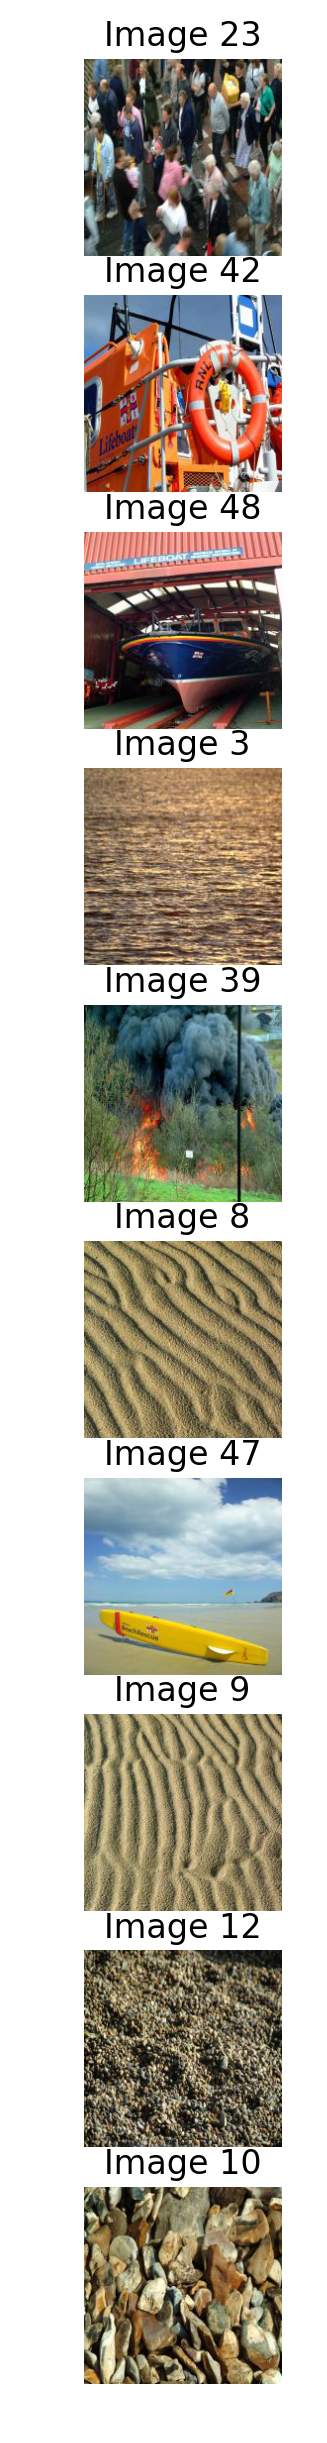

In [17]:
def manhattan(X, Y):
    return sum((abs(x - y) for x, y in zip(X, Y)))

k = 10 # Nombre de voisins à trouver

fig, axarr = plt.subplots(k, figsize=(15, 15))

neighbours = sorted(descriptors.items(), key=lambda x: manhattan(x[1].values(), descriptors[target_img].values()))

for i, neighbour in enumerate(neighbours[1:11]):
    image_file = 'img/{}.jpg'.format(str(neighbour[0]).zfill(2))
    axarr[i].imshow(imread(image_file))
    axarr[i].set_title('Image {}'.format(neighbour[0]))
    axarr[i].axis('off')